In [ ]:
pip install ipympl ipyplot umap-learn albumentations pydot mlxtend seaborn tensorflow_model_optimization tensorflow_addons umap-learn[plot]

In [1]:
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
import ipyplot as plt2
import seaborn as sns
import pandas as pd

raw_x = np.load("./data/train/train_images.npy")
raw_y = pd.read_csv("./data/train/train_labels.csv")
label2txt = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
raw_y["txtlabel"] = [label2txt[i] for i in raw_y["label"]]

# Labels
Each training and test example is assigned to one of the following labels:

| Label |	Description  |
|-------|----------------|
|   0   |	T-shirt/top  |
|   1   |	Trouser      |
|   2   |	Pullover     |
|   3   |	Dress        |
|   4   |	Coat         |
|   5   |	Sandal       |
|   6   |	Shirt        |
|   7   |	Sneaker      |
|   8   |	Bag          |
|   9   |	Ankle boot   |


# EDA

## Dataset sample viewing

In [2]:
txtlabels = [label2txt[i] for i in raw_y["label"]]
plt2.plot_class_tabs(raw_x, txtlabels, img_width=28, show_url=False, zoom_scale=3)

## Classes mean element vector

In [3]:
class_mean_x = [np.mean(raw_x[raw_y["label"]==i], (0)) for i in range(10)]
plt2.plot_images(class_mean_x)

## Per Class pixel intensity histogram

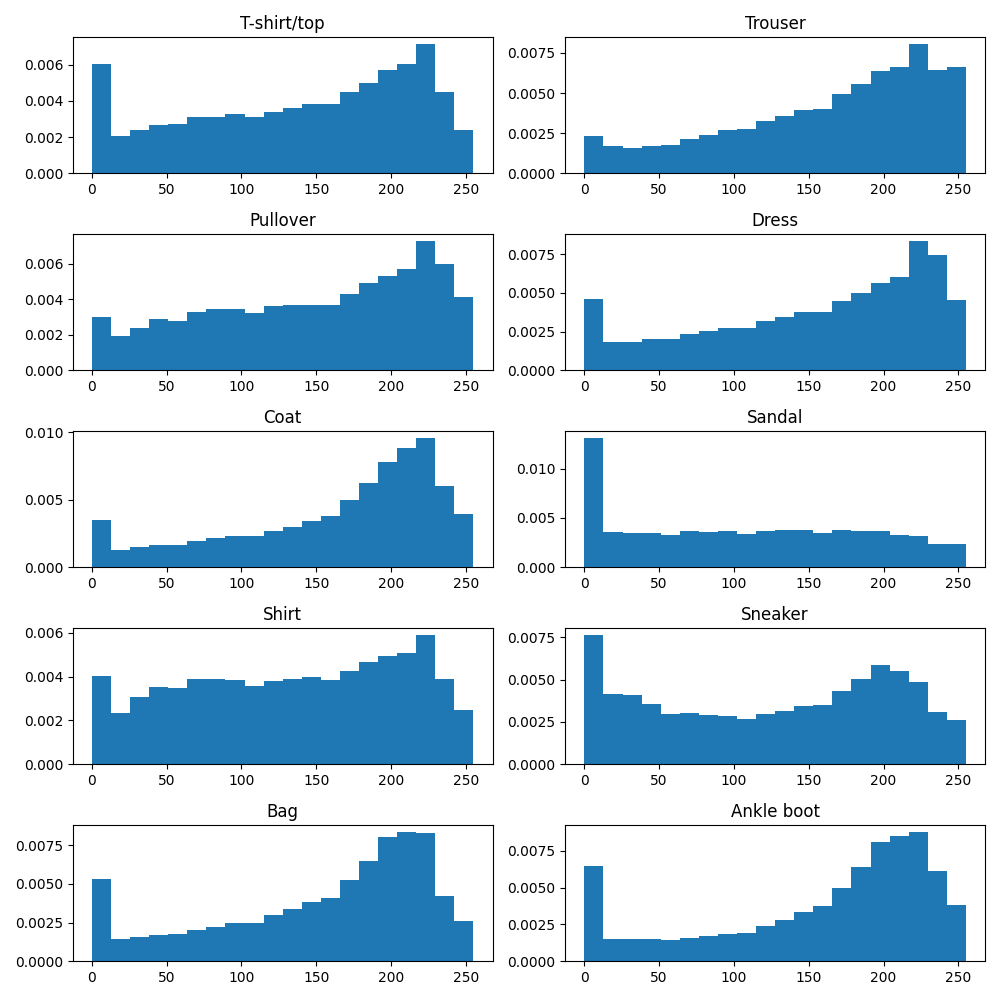

In [4]:
fig, axes = plt.subplots(5, 2, )
fig.set_figwidth(10)
fig.set_figheight(10)
fig.set_tight_layout(True)
for i in range(len(axes)):
    for j in range(len(axes[i])):
        axes[i, j].hist(raw_x[raw_y["label"]==(2*i+j)].flatten(), bins=20, density=True, range=(0.1, 255))
        axes[i,j].set_title(label2txt[2*i+j])
        
plt.show()

Se ve en los histogramas algunas caracteristicas que podrian distinguir las clases. De todas formas esto resulta de una generalizacion de pocas dimensiones. No creo que ayude a separar demasiado las imagenes en clases.

## PCA Dimension reduction

In [5]:
import sklearn.decomposition as dec

In [6]:
mean_x = np.mean(class_mean_x, 0)
mean_norm_x = raw_x - [mean_x for i in range(len(raw_x))]
flatten_x = np.array([img.flatten() for img in raw_x])

In [7]:
PCA_x = dec.PCA(n_components=3).fit_transform(flatten_x)
pca_df = pd.DataFrame.copy(raw_y)
pca_df["first dim"] = PCA_x[..., 0]
pca_df["second dim"] = PCA_x[..., 1]
pca_df["third dim"] = PCA_x[..., 2]
pca_df["txtlabel"] = txtlabels
pca_df

,label,txtlabel,first dim,second dim,third dim
0,9,Ankle boot,-123.993791,1633.074396,-1211.040915
1,0,T-shirt/top,1407.928853,-451.641336,-261.026803
2,0,T-shirt/top,-725.910795,-1101.838138,106.154460
3,3,Dress,31.398664,-981.067672,202.580488
4,0,T-shirt/top,804.119258,-1201.168720,-744.376573
...,...,...,...,...,...
59995,5,Sandal,-1725.093422,-41.582509,324.750558
59996,1,Trouser,-27.515977,-1454.424893,-455.665001
59997,3,Dress,857.750196,-1180.240183,-520.694747
59998,0,T-shirt/top,-807.476526,-581.218873,480.319994


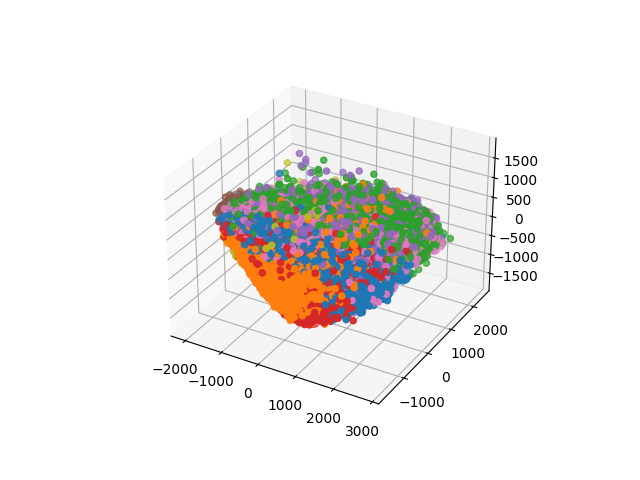

In [8]:
pca_3d_scatter = plt.figure()
ax = pca_3d_scatter.add_subplot(projection='3d')

ax.scatter3D(
    xs=pca_df["first dim"], ys=pca_df["second dim"], zs=pca_df["third dim"],
    c=pca_df["label"], 
    cmap='tab10',   
)
plt.show()

El PCA no permite separar las clases correctamente para 3 dimensiones. Se ve que los datos estan muy correlacionados en algunos casos.

## t-SNE analisys

In [9]:
import sklearn.manifold as mf

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.003s...
[t-SNE] Computed neighbors for 10000 samples in 2.344s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 455.672474
[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.504593
[t-SNE] KL divergence after 1000 iterations: 1.514181


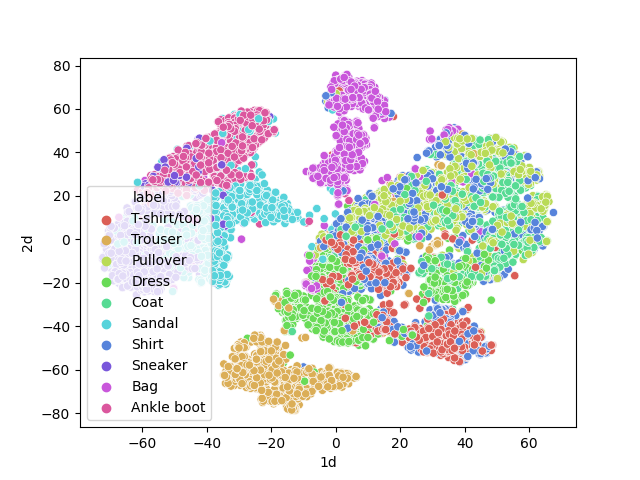

In [10]:
tsne_x = mf.TSNE(n_components=2, verbose=1, perplexity=40).fit_transform(flatten_x[:10000])

tsne_df = pd.DataFrame()
tsne_df["label"] = txtlabels[:10000]
tsne_df["1d"] = tsne_x[..., 0]
tsne_df["2d"] = tsne_x[..., 1]

plt.figure()
sns.scatterplot(
    x="1d", y="2d",
    hue="label",
    hue_order = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'],
    palette=sns.color_palette("hls", 10),
    data=tsne_df,

)
plt.show()

T-SNE Separa mejor que PCA, pero se puede ver que todavia mantiene confusion, un embedding de 2 dimensiones no separa las clases perfectamente pero se aproxima. Se ve las confusiones que tiene entre las remeras pullovers y ese tipo de prendas.

## UMap analysis

In [24]:
import umap.umap_ as umap

In [25]:
mapper = umap.UMAP().fit_transform(flatten_x[:30000])

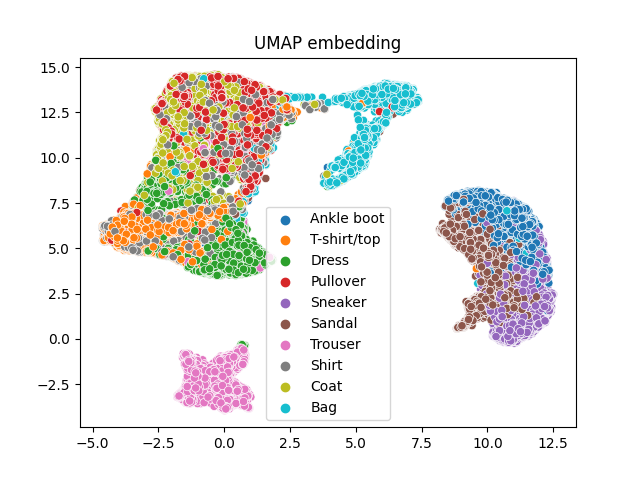

In [26]:

hover_data_df = pd.DataFrame({"Class": txtlabels[:30000]})
plt.figure()
sns.scatterplot(x=mapper[:, 0], y=mapper[:, 1], hue=txtlabels[:30000])
plt.title('UMAP embedding')
plt.show()

UMAP tambien separa bastante bien en 2 dimensiones, y se ve que clases van a ser las mas faciles de detectar. La mayor confusion se va a ver con las remeras pullovers y ese tipo de prendas.

# Model Training:


**Micro vs Macro Avaraging** 

Fuente: https://towardsdatascience.com/micro-macro-weighted-averages-of-f1-score-clearly-explained-b603420b292f#989c

Para el caso de multiclase, macroavaraging es la eleccion correcta. Dado que la cantidad de elementos en cada clase es identico, tampoco tiene sentido pesar el macroavarage de las metricas. Tomar el microavaraging no genera informacion ya que todas las metricas de recall precision y F1-score dan lo mismo. Macro avarage da un promedio de que tan bien dan las metricas para cada clase, y micro avarage da una metrica del funcionamiento general del modelo

In [27]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
%reload_ext autoreload
%autoreload 2
from helper import *

from tensorflow.keras import optimizers as opt
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, RandomFlip, RandomBrightness
from tensorflow.keras import Sequential, models
from tensorflow_addons.optimizers import CyclicalLearningRate, Triangular2CyclicalLearningRate, TriangularCyclicalLearningRate

metrics=['accuracy', 'AUC']

keras.utils.set_random_seed(seed)

/home/gullino18/anaconda3/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


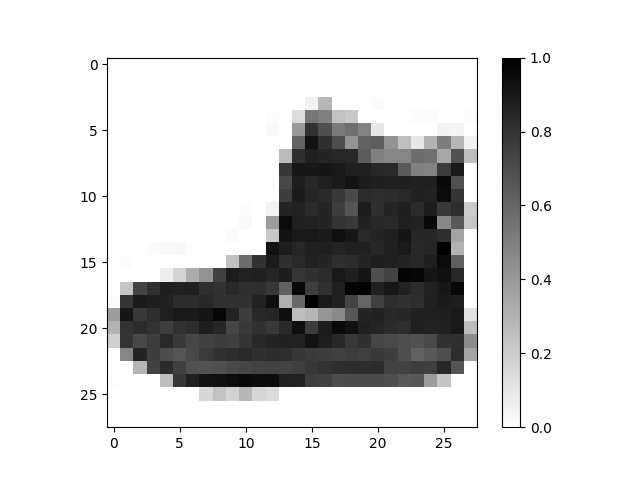

In [28]:
casted_x = np.array(raw_x, dtype="float32")
normalized_x = casted_x / 255
plt.figure()
plt.imshow(normalized_x[0], cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

Normalizacion minmax para las imagenes

In [29]:
onehot_y = keras.utils.to_categorical(raw_y["label"], num_classes=10)
split = int(len(normalized_x)*0.9/10)
train_index = [i for i, lab in enumerate(raw_y["label"]) if lab==0][:split]
test_index = [i for i, lab in enumerate(raw_y["label"]) if lab==0][split:]

for j in range(1, 10):
    train_index = train_index + [i for i, lab in enumerate(raw_y["label"]) if lab==j][:split]
    test_index += [i for i, lab in enumerate(raw_y["label"]) if lab==j][split:]

Split de datos entre train y test. 90% Train, 10% Test. Es un spliteo parejo entre clases.

## Simple Softmax model: Base Line


In [30]:

tf.keras.utils.set_random_seed(hash("Los buenos caballos y los buenos estudiantes siempre terminan su carrera.") % 2**32)

model = Sequential()
model.add(Flatten(input_shape=(28,28)))
model.add(Dense(10, activation='softmax'))
model.summary()
model.compile(optimizer=opt.SGD(learning_rate=.01), loss='categorical_crossentropy', metrics=metrics)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 10)                7850      
                                                                 
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


In [31]:
earlyStopCB = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, start_from_epoch=8)
LearningSchedulerCB = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, min_lr=5e-9, patience=5)
history = model.fit(x=normalized_x[train_index], y=onehot_y[train_index], batch_size=256, epochs=1000, shuffle=True, validation_data=(normalized_x[test_index], onehot_y[test_index]), callbacks=[earlyStopCB, LearningSchedulerCB])

Epoch 1/1000
211/211 [==============================] - 2s 7ms/step - loss: 1.4399 - accuracy: 0.5791 - auc: 0.9099 - val_loss: 1.0437 - val_accuracy: 0.6885 - val_auc: 0.9614 - lr: 0.0100
Epoch 2/1000
211/211 [==============================] - 2s 9ms/step - loss: 0.9467 - accuracy: 0.7062 - auc: 0.9654 - val_loss: 0.8597 - val_accuracy: 0.7293 - val_auc: 0.9703 - lr: 0.0100
Epoch 3/1000
211/211 [==============================] - 2s 10ms/step - loss: 0.8266 - accuracy: 0.7374 - auc: 0.9708 - val_loss: 0.7799 - val_accuracy: 0.7505 - val_auc: 0.9736 - lr: 0.0100
Epoch 4/1000
211/211 [==============================] - 2s 9ms/step - loss: 0.7638 - accuracy: 0.7571 - auc: 0.9736 - val_loss: 0.7319 - val_accuracy: 0.7637 - val_auc: 0.9756 - lr: 0.0100
Epoch 5/1000
211/211 [==============================] - 1s 6ms/step - loss: 0.7229 - accuracy: 0.7711 - auc: 0.9755 - val_loss: 0.6975 - val_accuracy: 0.7728 - val_auc: 0.9772 - lr: 0.0100
Epoch 6/1000
211/211 [==============================] 

188/188 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

 T-shirt/top       0.82      0.82      0.82       600
     Trouser       0.98      0.94      0.96       600
    Pullover       0.75      0.77      0.76       600
       Dress       0.84      0.88      0.86       600
        Coat       0.75      0.76      0.75       600
      Sandal       0.94      0.90      0.92       600
       Shirt       0.65      0.59      0.62       600
     Sneaker       0.89      0.93      0.91       600
         Bag       0.92      0.94      0.93       600
  Ankle boot       0.94      0.94      0.94       600

    accuracy                           0.85      6000
   macro avg       0.85      0.85      0.85      6000
weighted avg       0.85      0.85      0.85      6000



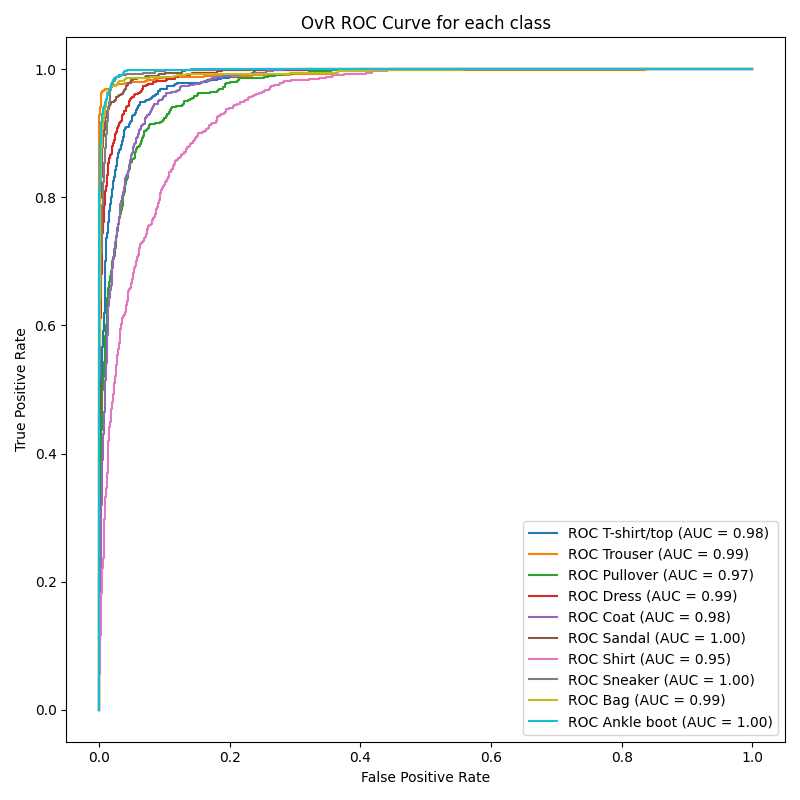

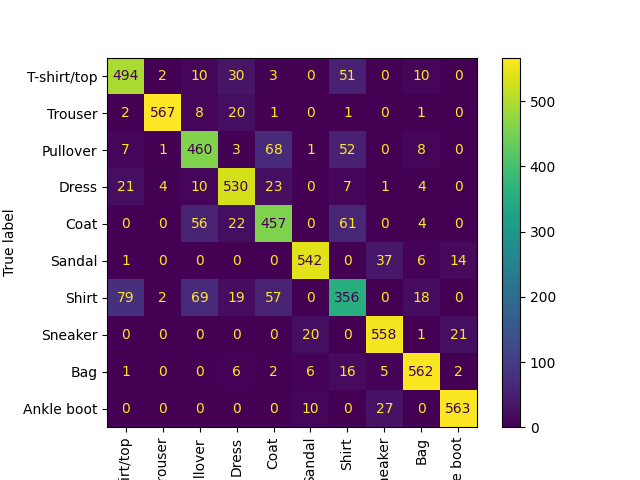

In [32]:
model_evaluation(onehot_y[test_index], model.predict(normalized_x[test_index]))

El softmax se confunde mucho con las remeras, pero en lo demas funciona bien

## Multi Layer Perceptron Models

### HyperParameters Search

In [ ]:
hyperparam_search(normalized_x[train_index], onehot_y[train_index], normalized_x[test_index], onehot_y[test_index])

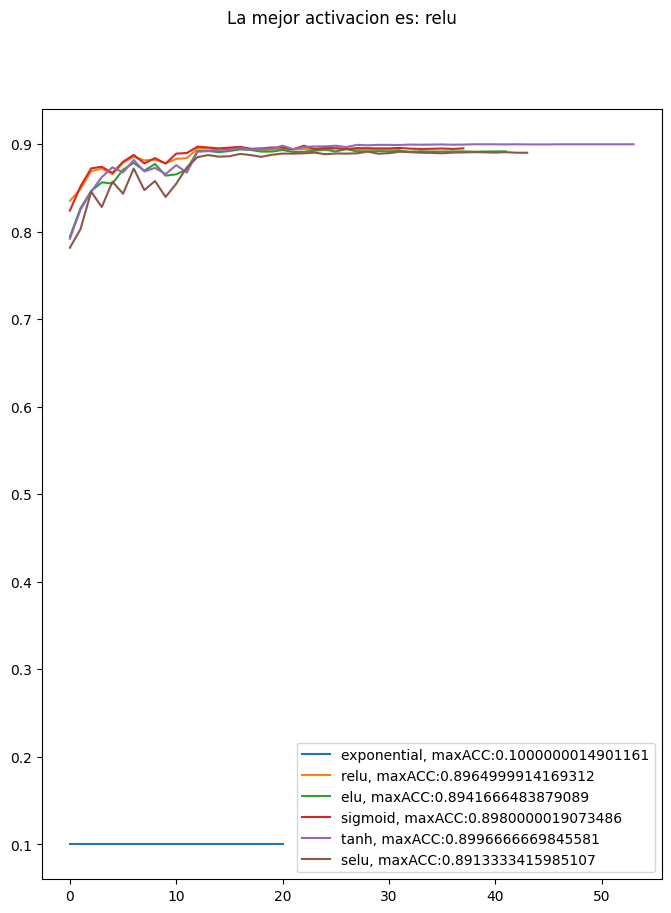

La mejor activacion termina siendo Relu ya que converge rapidamente a un buen valor de accuracy, pero esta prueba no demuestra la superioridad total de Relu sobre otras activaciones ya que todas alcanzan accuracys bastante buenas.

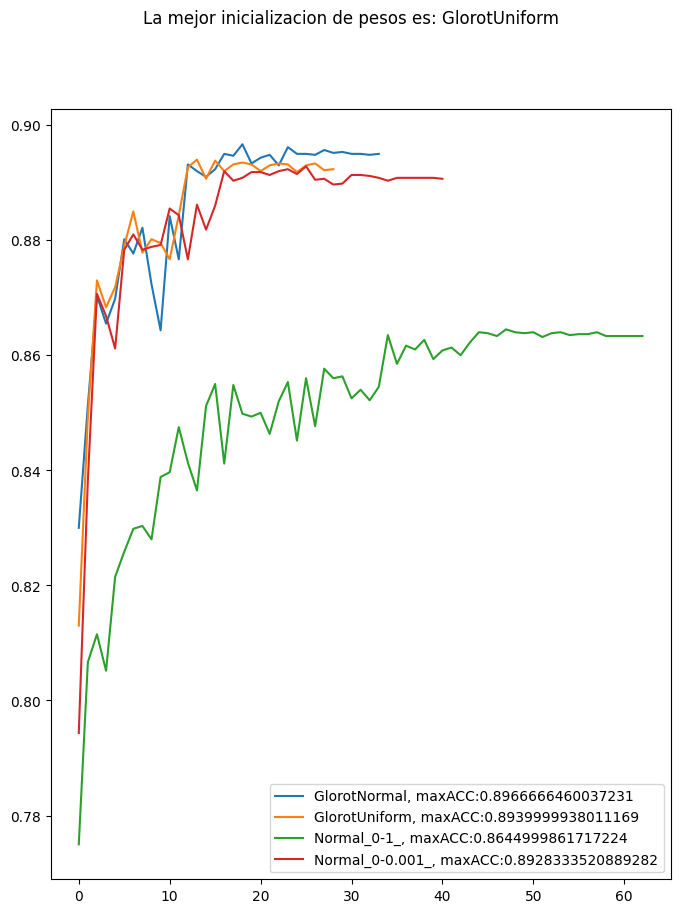

En este caso, el mejor score lo recibe Glorot Normal, pero la Glorot Uniforme alcanza accuracy superior, por lo que se considera mejor para este caso. Y es la que se utilizó a lo largo de toda la busqueda de hyperparametros

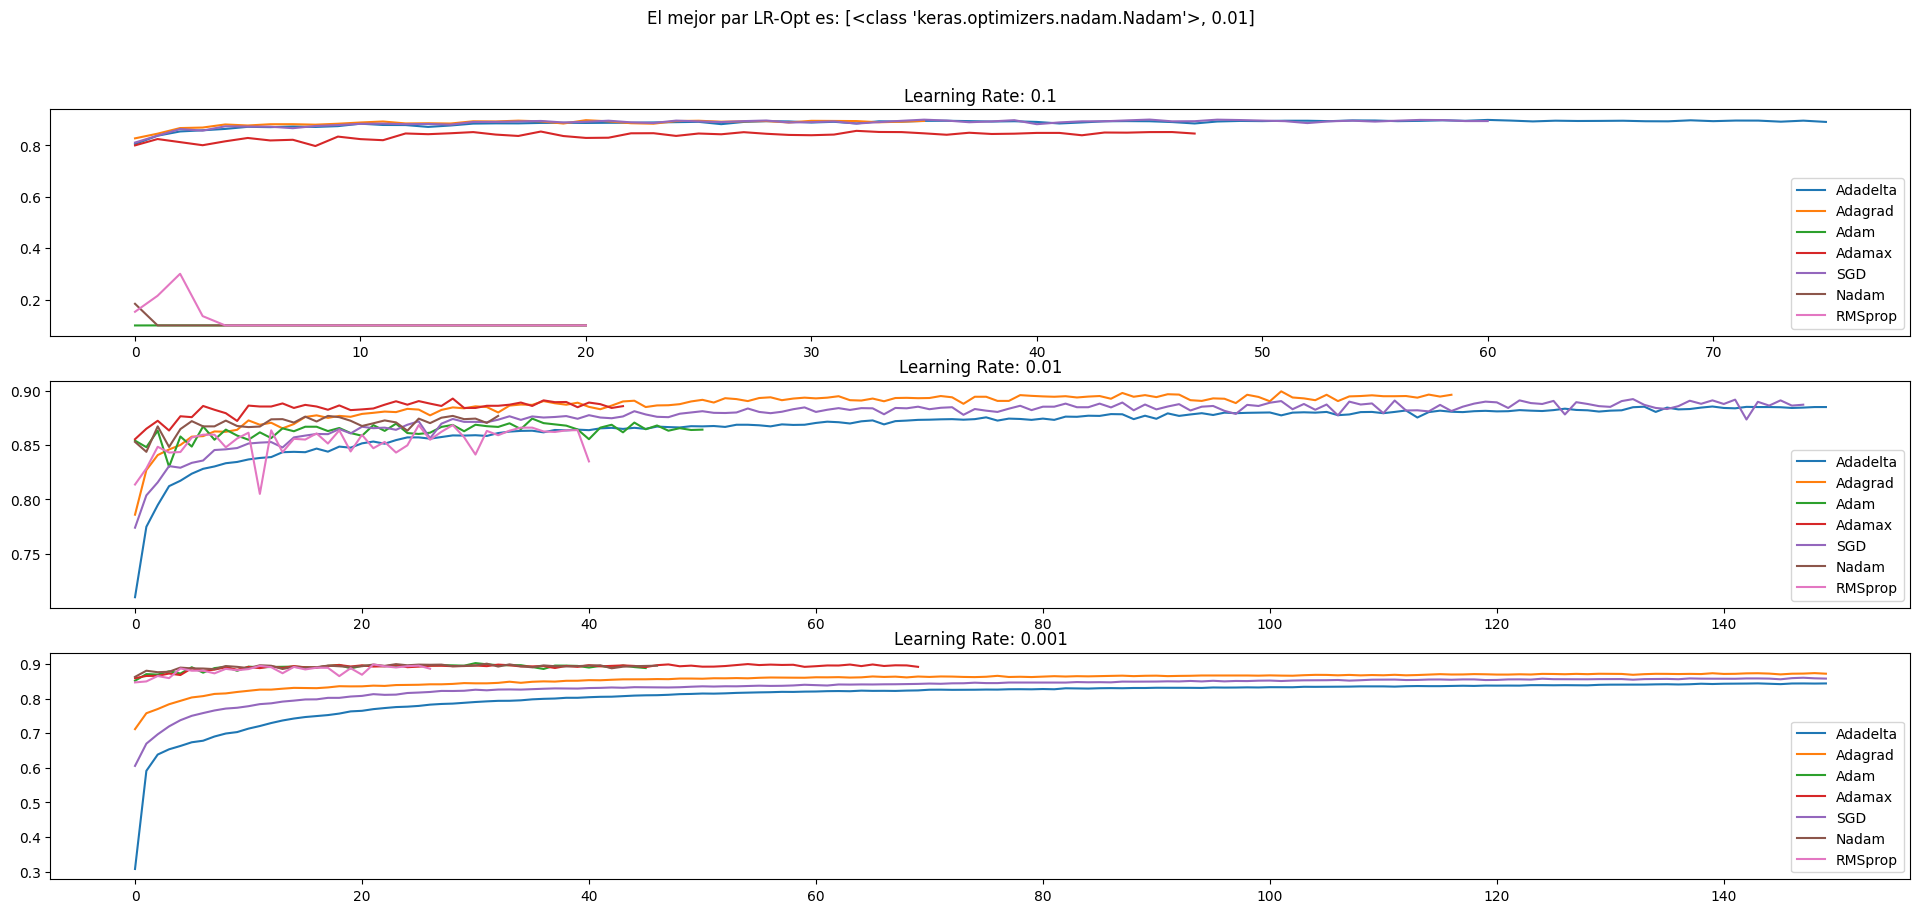

**Recomiendo abrir la imagen por separado**

En este caso se puede ver que para el learning rate mas alto la mayoria de los modelos se comportan de forma similar salvo por Adamax y Nadam, Adam y RMSprop. Para el caso de learning rate 0.01 (mejor learning rate) se puede ver que el mejor modelo es Adamax, pero el score da mejor para Nadam porque se estabiliza antes. Ambos se tendran en cuenta al momento de entrenar, pero predominara Adamax.

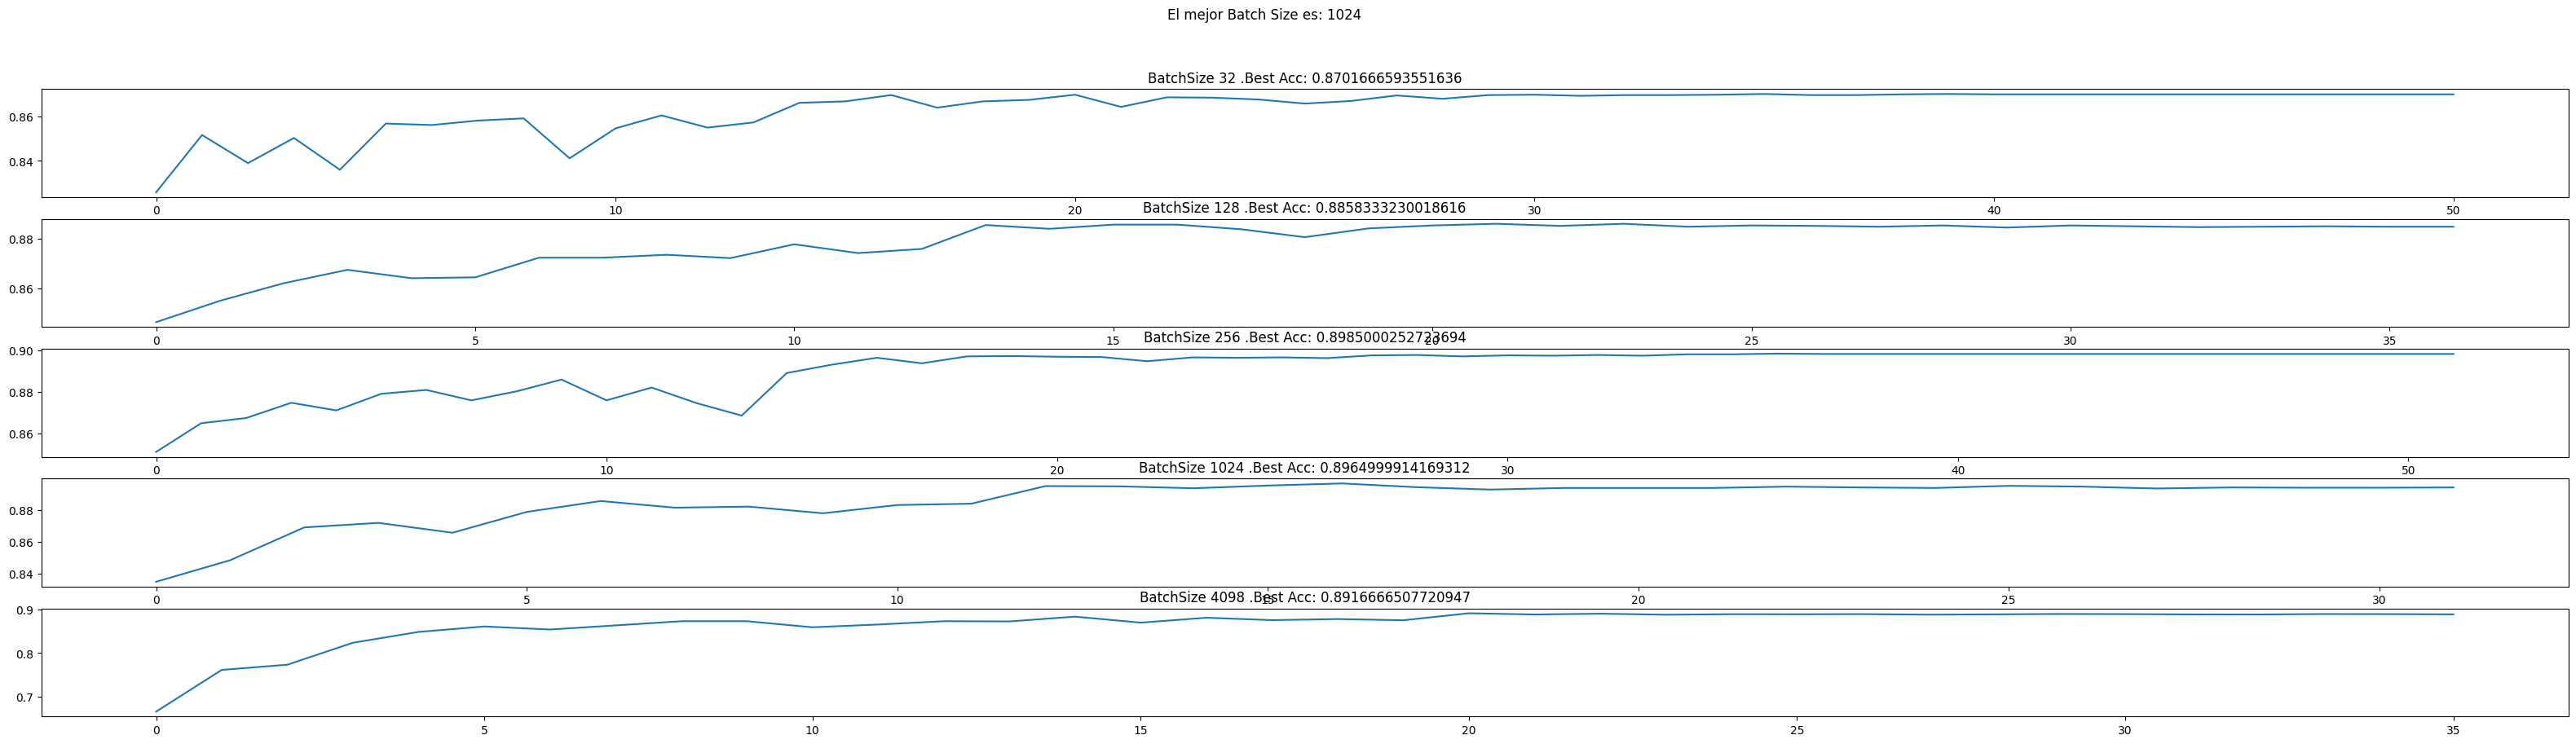

**Recomiendo abrir la imagen por separado**

En este caso el mejor Batch Size se encuentra entre 256 y 1024, se elige 1024 ya que no tiene una mejora significativa frente a un batch size mas chico. Se gana en tiempo de entrenamiento.


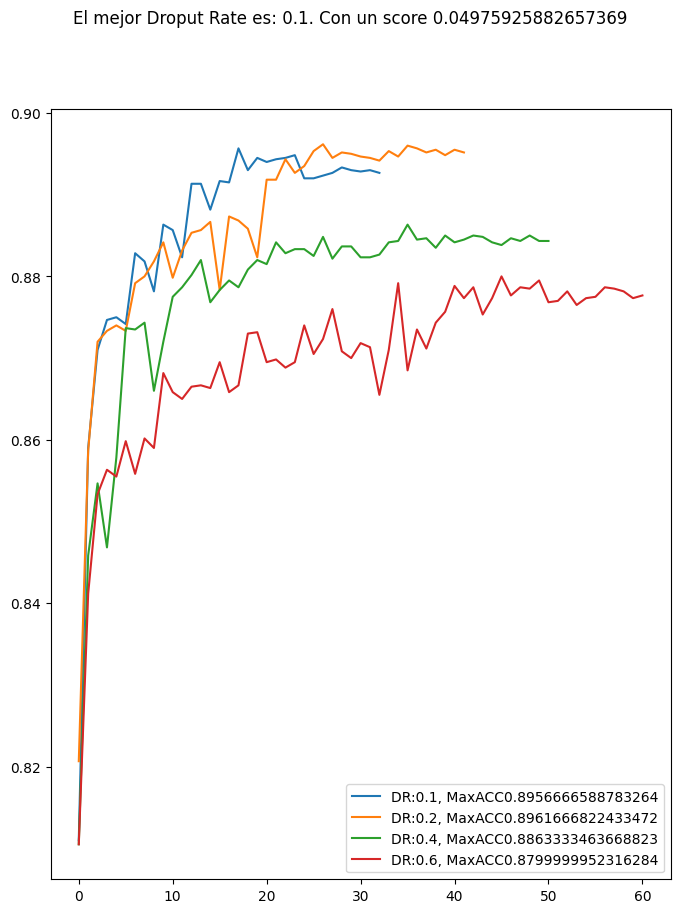

Parece ser que el Dropout rate entre 0.1 y 0.2 es similar, pero prevalece 0.2

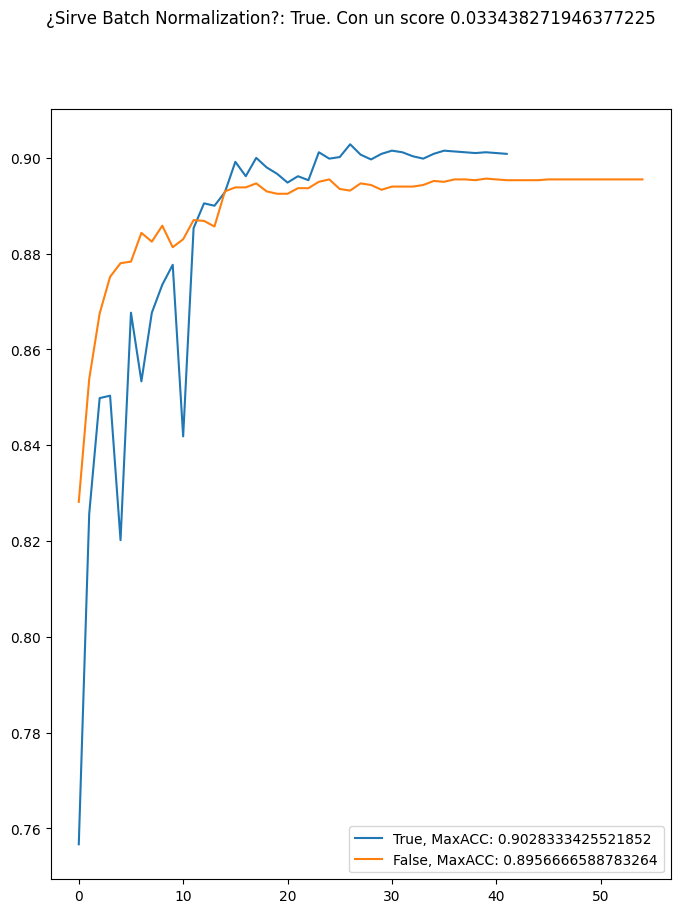

El batch normalization arroja buenos resultados. En las pruebas reales no resulto tan superior.

En general son resultados esperados por la experimentacion previa que realice con modelos jugando a mano. Los modelos siguientes usan un poco lo que consegui a mano, y lo que saque de mejora en este analisis.

## Lottery Ticket Hypotesis (Anda raro)

### Modelo 1

In [33]:
model1 = Sequential()
model1.add(Flatten(input_shape=(28, 28)))
model1.add(Dense(512, activation='relu'))
model1.add(Dense(512, activation='relu'))
model1.add(Dense(512, activation='relu'))
model1.add(Dense(10, activation='softmax'))
model1.compile(optimizer=opt.Adamax(learning_rate=0.01), loss='categorical_crossentropy', metrics=metrics)
model1.summary()

model1.save("./LotteryTicketModels/Model1")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               401920    
                                                                 
 dense_2 (Dense)             (None, 512)               262656    
                                                                 
 dense_3 (Dense)             (None, 512)               262656    
                                                                 
 dense_4 (Dense)             (None, 10)                5130      
                                                                 
Total params: 932,362
Trainable params: 932,362
Non-trainable params: 0
_________________________________________________________________


INFO:tensorflow:Assets written to: ./LotteryTicketModels/Model1/assets


INFO:tensorflow:Assets written to: ./LotteryTicketModels/Model1/assets


### Modelo 2

In [34]:
model2 = models.load_model("./LotteryTicketModels/Model1")
earlyStopCB = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, start_from_epoch=8)
LearningSchedulerCB = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, min_lr=5e-9, patience=5)
history = model2.fit(x=normalized_x[train_index], y=onehot_y[train_index], batch_size=256, epochs=1000, shuffle=True, validation_data=(normalized_x[test_index], onehot_y[test_index]), callbacks=[earlyStopCB, LearningSchedulerCB])
model2.save("./LotteryTicketModels/Model2")

Epoch 1/1000
211/211 [==============================] - 6s 27ms/step - loss: 0.7185 - accuracy: 0.7755 - auc: 0.9726 - val_loss: 0.4398 - val_accuracy: 0.8397 - val_auc: 0.9875 - lr: 0.0100
Epoch 2/1000
211/211 [==============================] - 6s 29ms/step - loss: 0.3842 - accuracy: 0.8591 - auc: 0.9903 - val_loss: 0.3912 - val_accuracy: 0.8595 - val_auc: 0.9899 - lr: 0.0100
Epoch 3/1000
211/211 [==============================] - 6s 26ms/step - loss: 0.3421 - accuracy: 0.8742 - auc: 0.9922 - val_loss: 0.3580 - val_accuracy: 0.8723 - val_auc: 0.9913 - lr: 0.0100
Epoch 4/1000
211/211 [==============================] - 5s 24ms/step - loss: 0.3182 - accuracy: 0.8819 - auc: 0.9932 - val_loss: 0.3427 - val_accuracy: 0.8753 - val_auc: 0.9919 - lr: 0.0100
Epoch 5/1000
211/211 [==============================] - 5s 24ms/step - loss: 0.2989 - accuracy: 0.8896 - auc: 0.9939 - val_loss: 0.3217 - val_accuracy: 0.8772 - val_auc: 0.9931 - lr: 0.0100
Epoch 6/1000
211/211 [============================

INFO:tensorflow:Assets written to: ./LotteryTicketModels/Model2/assets


INFO:tensorflow:Assets written to: ./LotteryTicketModels/Model2/assets


### Modelo 3

In [ ]:
model2 = models.load_model("./LotteryTicketModels/Model2")
model3 = models.load_model("./LotteryTicketModels/Model1")

weights1 = model3.get_weights()
weights2 = model2.get_weights()
weights3 = [np.zeros(weights1[i].shape) for i in range(len(weights1))]

for i, weights in enumerate(zip(weights1, weights2)):
    if len(weights[0].shape) == 1:
        continue
    diference = np.abs(weights[0]-weights[1])
    y_size, x_size = weights[0].shape
    sorted_indexes = np.argsort(diference.flatten())
    for index in sorted_indexes[:int(len(sorted_indexes)//2)]:
        x_index = int(np.mod(index, x_size))
        y_index = int(index // x_size)
        weights3[i][y_index][x_index] = weights1[i][y_index][x_index]
        
model3.set_weights(weights3)
model3.compile(optimizer=opt.Adamax(learning_rate=0.01), loss='categorical_crossentropy', metrics=metrics)
model3.save("./LotteryTicketModels/Model3NotTrained")



In [37]:
model3 = models.load_model("./LotteryTicketModels/Model3NotTrained")
results = model3.evaluate(normalized_x[test_index], onehot_y[test_index])

188/188 [==============================] - 2s 11ms/step - loss: 2.2663 - accuracy: 0.2102 - auc_1: 0.5884


In [38]:
model3 = models.load_model("./LotteryTicketModels/Model3NotTrained")
model3.build()
earlyStopCB = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, start_from_epoch=8)
LearningSchedulerCB = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, min_lr=5e-9, patience=5)
history = model3.fit(x=normalized_x[train_index], y=onehot_y[train_index], batch_size=1024, epochs=1000, shuffle=True, validation_data=(normalized_x[test_index], onehot_y[test_index]), callbacks=[earlyStopCB, LearningSchedulerCB])
model3.save("./LotteryTicketModels/Model3Trained")

Epoch 1/1000
53/53 [==============================] - 3s 57ms/step - loss: 1.2721 - accuracy: 0.6481 - auc_1: 0.9267 - val_loss: 0.5039 - val_accuracy: 0.8117 - val_auc_1: 0.9846 - lr: 0.0100
Epoch 2/1000
53/53 [==============================] - 3s 51ms/step - loss: 0.4623 - accuracy: 0.8333 - auc_1: 0.9866 - val_loss: 0.4269 - val_accuracy: 0.8415 - val_auc_1: 0.9884 - lr: 0.0100
Epoch 3/1000
53/53 [==============================] - 3s 51ms/step - loss: 0.3902 - accuracy: 0.8589 - auc_1: 0.9901 - val_loss: 0.4021 - val_accuracy: 0.8542 - val_auc_1: 0.9899 - lr: 0.0100
Epoch 4/1000
53/53 [==============================] - 3s 52ms/step - loss: 0.3519 - accuracy: 0.8718 - auc_1: 0.9919 - val_loss: 0.3720 - val_accuracy: 0.8620 - val_auc_1: 0.9906 - lr: 0.0100
Epoch 5/1000
53/53 [==============================] - 3s 55ms/step - loss: 0.3290 - accuracy: 0.8788 - auc_1: 0.9929 - val_loss: 0.3379 - val_accuracy: 0.8735 - val_auc_1: 0.9923 - lr: 0.0100
Epoch 6/1000
53/53 [====================

INFO:tensorflow:Assets written to: ./LotteryTicketModels/Model3Trained/assets


INFO:tensorflow:Assets written to: ./LotteryTicketModels/Model3Trained/assets


In [40]:
model3 = models.load_model("./LotteryTicketModels/Model3Trained")
model2 = models.load_model("./LotteryTicketModels/Model2")
print("Model 2:")
model2.evaluate(normalized_x[test_index], onehot_y[test_index])
print("Model 3:")
model3.evaluate(normalized_x[test_index], onehot_y[test_index])

Model 2:
188/188 [==============================] - 2s 9ms/step - loss: 0.3208 - accuracy: 0.8930 - auc: 0.9913
Model 3:
188/188 [==============================] - 1s 6ms/step - loss: 0.3127 - accuracy: 0.8952 - auc_1: 0.9921


[0.3127448856830597, 0.8951666951179504, 0.9921405911445618]

Por algun motivo no puedo lograr que los pesos marcados permanezcan en 0. de todas formas hay una pequeña mejora en el modelo 3

## Good Model: classification boundary plot

In [41]:
tf.keras.utils.set_random_seed(hash("Los buenos caballos y los buenos estudiantes siempre terminan su carrera.") % 2**32)

model = Sequential()
model.add(Flatten(input_shape=(28,28)))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2))
model.add(Dense(10, activation='softmax'))

clr = Triangular2CyclicalLearningRate(5e-5, 0.01, 5 * 196)
model.summary()
model.compile(optimizer=opt.Adamax(learning_rate=clr), loss='categorical_crossentropy', metrics=metrics)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_5 (Dense)             (None, 512)               401920    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 512)               262656    
                                                                 
 dropout_2 (Dropout)         (None, 512)              

In [42]:
earlyStopCB = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, start_from_epoch=8)
LearningSchedulerCB = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, min_lr=5e-9, patience=5)
history = model.fit(x=normalized_x[train_index], y=onehot_y[train_index], batch_size=256, epochs=1000, shuffle=True, validation_data=(normalized_x[test_index], onehot_y[test_index]), callbacks=[earlyStopCB, LearningSchedulerCB])

Epoch 1/1000
211/211 [==============================] - 7s 33ms/step - loss: 1.4862 - accuracy: 0.4473 - auc: 0.8692 - val_loss: 1.0567 - val_accuracy: 0.5582 - val_auc: 0.9380 - lr: 0.0022
Epoch 2/1000
211/211 [==============================] - 7s 32ms/step - loss: 0.8576 - accuracy: 0.7020 - auc: 0.9601 - val_loss: 0.7001 - val_accuracy: 0.7968 - val_auc: 0.9727 - lr: 0.0043
Epoch 3/1000
211/211 [==============================] - 7s 33ms/step - loss: 0.6281 - accuracy: 0.8136 - auc: 0.9780 - val_loss: 0.5736 - val_accuracy: 0.8335 - val_auc: 0.9809 - lr: 0.0065
Epoch 4/1000
211/211 [==============================] - 8s 37ms/step - loss: 0.5505 - accuracy: 0.8282 - auc: 0.9822 - val_loss: 0.5197 - val_accuracy: 0.8393 - val_auc: 0.9832 - lr: 0.0086
Epoch 5/1000
211/211 [==============================] - 8s 36ms/step - loss: 0.5126 - accuracy: 0.8337 - auc: 0.9842 - val_loss: 0.4971 - val_accuracy: 0.8445 - val_auc: 0.9849 - lr: 0.0092
Epoch 6/1000
211/211 [============================

188/188 [==============================] - 2s 8ms/step
              precision    recall  f1-score   support

 T-shirt/top       0.84      0.87      0.86       600
     Trouser       1.00      0.96      0.98       600
    Pullover       0.80      0.81      0.80       600
       Dress       0.89      0.93      0.91       600
        Coat       0.84      0.78      0.81       600
      Sandal       0.97      0.95      0.96       600
       Shirt       0.73      0.73      0.73       600
     Sneaker       0.92      0.96      0.94       600
         Bag       0.98      0.97      0.98       600
  Ankle boot       0.97      0.95      0.96       600

    accuracy                           0.89      6000
   macro avg       0.89      0.89      0.89      6000
weighted avg       0.89      0.89      0.89      6000



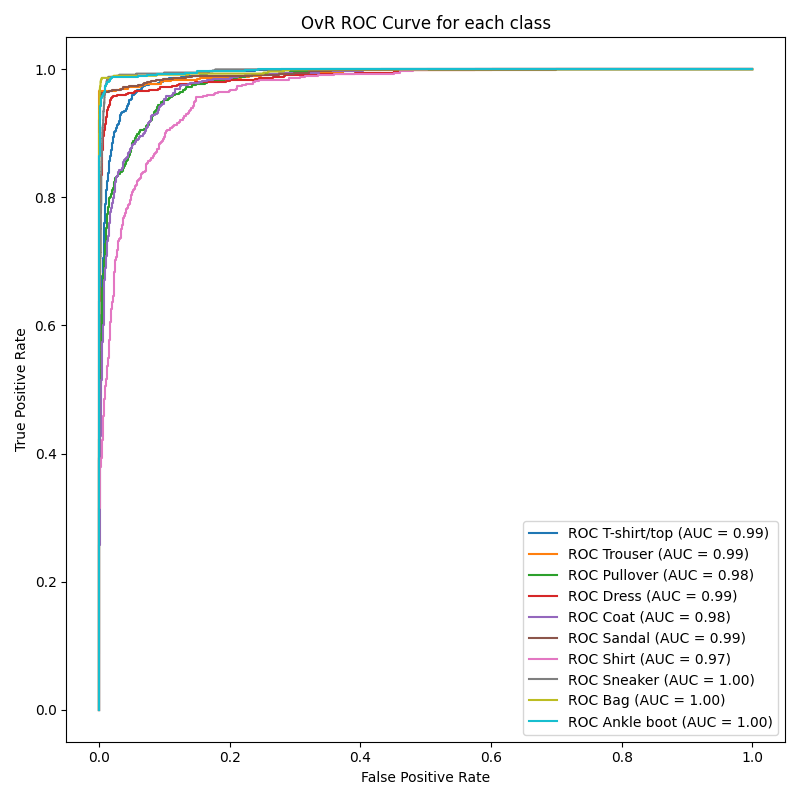

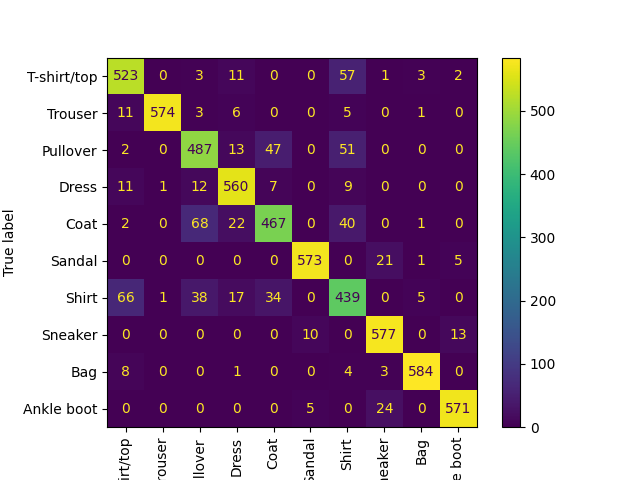

In [43]:
model_evaluation(onehot_y[test_index], model.predict(normalized_x[test_index]))

20116/20116 [==============================] - 22s 1ms/step


/home/gullino18/Documents/Github/TP01-RN/Clasificador/helper.py:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'])


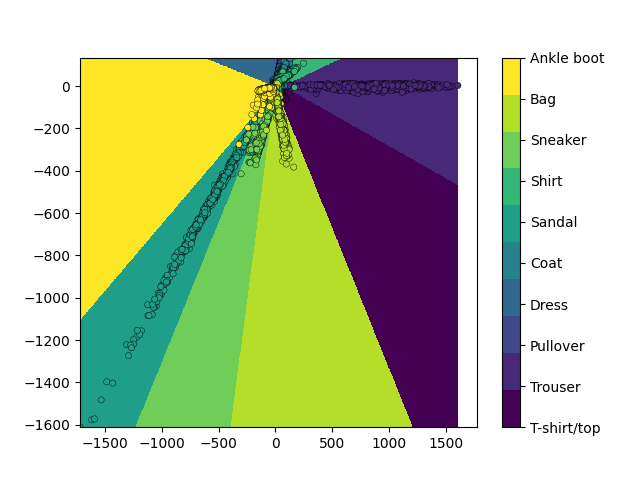

In [45]:
plot_decision_bounds(model, normalized_x[test_index], raw_y["label"][test_index].values)

Muy interesante ver las remeras segregadas al centro por ser las que llevan mas confusion. Le re cuesta aprender esa diferencia

## Submissions

Algunos modelos que dieron los mejores resultados. Son los mejores que consegui

### 0.90420

In [ ]:
tf.keras.utils.set_random_seed(hash("Los buenos caballos y los buenos estudiantes siempre terminan su carrera.") % 2**32)

model = Sequential()
model.add(Flatten(input_shape=(28,28)))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(10, activation='softmax'))

model.summary()
model.compile(optimizer=opt.Adamax(learning_rate=0.01), loss='categorical_crossentropy', metrics=metrics)

In [ ]:
earlyStopCB = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, start_from_epoch=8)
LearningSchedulerCB = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, min_lr=5e-9, patience=5)
history = model.fit(x=normalized_x[train_index], y=onehot_y[train_index], batch_size=32, epochs=1000, shuffle=True, validation_data=(normalized_x[test_index], onehot_y[test_index]), callbacks=[earlyStopCB, LearningSchedulerCB])

In [ ]:
model_evaluation(onehot_y[test_index], model.predict(normalized_x[test_index]))

### 0.90280

In [ ]:
tf.keras.utils.set_random_seed(hash("Los buenos caballos y los buenos estudiantes siempre terminan su carrera.") % 2**32)

model = Sequential()
model.add(Flatten(input_shape=(28,28)))
model.add(Dense(2048, activation='relu'))
model.add(Dense(1024, activation='relu'))

model.add(Dense(10, activation='softmax'))
model.summary()
model.compile(optimizer=opt.Adamax(learning_rate=.001), loss='categorical_crossentropy', metrics=metrics)

In [ ]:
earlyStopCB = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, start_from_epoch=8)
LearningSchedulerCB = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, min_lr=5e-9, patience=5)
history = model.fit(x=normalized_x[train_index], y=onehot_y[train_index], batch_size=32, epochs=1000, shuffle=True, validation_data=(normalized_x[test_index], onehot_y[test_index]), callbacks=[earlyStopCB, LearningSchedulerCB])

In [ ]:
model_evaluation(onehot_y[test_index], model.predict(normalized_x[test_index]))


### 0.90320

In [ ]:
tf.keras.utils.set_random_seed(hash("Los buenos caballos y los buenos estudiantes siempre terminan su carrera.") % 2**32)

model = Sequential()
model.add(Flatten(input_shape=(28,28)))
model.add(Dense(2048, activation='relu'))
model.add(Dense(2048, activation='relu'))

model.add(Dense(10, activation='softmax'))
model.summary()
model.compile(optimizer=opt.Adamax(learning_rate=.001), loss='categorical_crossentropy', metrics=metrics)

In [ ]:
earlyStopCB = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, start_from_epoch=8)
LearningSchedulerCB = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, min_lr=5e-9, patience=5)
history = model.fit(x=normalized_x[train_index], y=onehot_y[train_index], batch_size=32, epochs=1000, shuffle=True, validation_data=(normalized_x[test_index], onehot_y[test_index]), callbacks=[earlyStopCB, LearningSchedulerCB])

In [ ]:
model_evaluation(onehot_y[test_index], model.predict(normalized_x[test_index]))


### Data augmentation

El Data augmentation no me aporto nada para este modelo ):

#### Model with Augmented Data

In [ ]:
tf.keras.utils.set_random_seed(hash("Los buenos caballos y los buenos estudiantes siempre terminan su carrera.") % 2**32)

model = Sequential()
model.add(RandomFlip(mode="horizontal", seed=seed, input_shape=(28,28)))
model.add(Flatten(input_shape=(28,28)))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(10, activation='softmax'))

model.compile(optimizer=opt.Adamax(learning_rate=.001), loss='categorical_crossentropy', metrics=metrics)
model.summary()

#### Model without Augmented Data

In [ ]:
tf.keras.utils.set_random_seed(hash("Los buenos caballos y los buenos estudiantes siempre terminan su carrera.") % 2**32)

model = Sequential()
model.add(Flatten(input_shape=(28,28)))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(10, activation='softmax'))

model.compile(optimizer=opt.Adamax(learning_rate=.001), loss='categorical_crossentropy', metrics=metrics)
model.summary()

In [ ]:
earlyStopCB = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, start_from_epoch=8)
LearningSchedulerCB = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, min_lr=5e-9, patience=5)
history = model.fit(x=normalized_x[train_index], y=onehot_y[train_index], batch_size=256, epochs=1000, shuffle=True, validation_data=(normalized_x[test_index], onehot_y[test_index]), callbacks=[earlyStopCB, LearningSchedulerCB])

In [ ]:
model_evaluation(onehot_y[test_index], model.predict(normalized_x[test_index]))

## Submission generator

In [ ]:
submission = pd.DataFrame()
data = np.load("./data/test/test_images.npy")/255
submission["id"] = np.arange(len(data))
submission["Category"] = np.argmax(model.predict(data), (1))
submission.to_csv("submission.csv", index=False)
